In [61]:
# sns.set_palette('colorblind')
# sns.pairplot(data=data, height=3)

In [62]:
#import libraries
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# from sklearn.externals import joblib


In [63]:
data = pd.read_csv('diabetes_binary_5050split_health_indicators_BRFSS2015.csv')
data.shape

(70692, 22)

In [64]:
#check for completeness of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

                      Diabetes_binary    HighBP  HighChol  CholCheck  \
Diabetes_binary              1.000000  0.381516  0.289213   0.115382   
HighBP                       0.381516  1.000000  0.316515   0.103283   
HighChol                     0.289213  0.316515  1.000000   0.085981   
CholCheck                    0.115382  0.103283  0.085981   1.000000   
BMI                          0.293373  0.241019  0.131309   0.045648   
Smoker                       0.085999  0.087438  0.093398  -0.004331   
Stroke                       0.125427  0.129060  0.099786   0.022529   
HeartDiseaseorAttack         0.211523  0.210750  0.181187   0.043497   
PhysActivity                -0.158666 -0.136102 -0.090453  -0.008249   
Fruits                      -0.054077 -0.040852 -0.047384   0.017384   
Veggies                     -0.079293 -0.066624 -0.042836   0.000349   
HvyAlcoholConsump           -0.094853 -0.027030 -0.025443  -0.027146   
AnyHealthcare                0.023191  0.035764  0.031532   0.10

<AxesSubplot:>

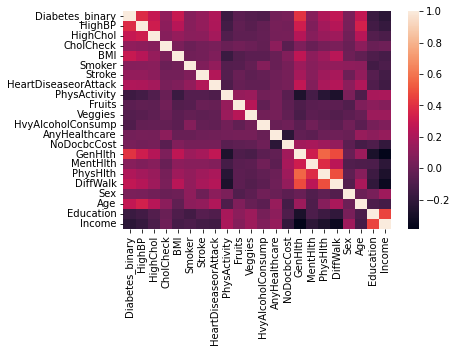

In [65]:
#correlation of every pair of features
#brighter colors indicate more correlation
corr = data.corr()
print(corr)
sns.heatmap(corr, 
         xticklabels=corr.columns, 
         yticklabels=corr.columns)

Initial Data Visualization Interpretations from Heatmap

1. HighBP, HighChol, BMI, HeartDiseaseorAttack, GenHlth, and Age all have significant correlation with the outcome variable.

In [66]:
#Splitting Features and Label
y = data.iloc[:,0]
X = data.iloc[:,1:-1]

In [67]:
#scale data? binary data so we don't need to scale i think

#split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 99)



In [68]:
#training and fitting Logistic Regression to model
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X_train,y_train)

#evaluating model
accuracy = model.score(X_test, y_test)
print("accuracy = ", accuracy * 100, "%")


accuracy =  74.63221425877028 %


In [69]:
print(model.intercept_)
print(model.coef_)

[-6.75341331]
[[ 7.44800746e-01  5.93528487e-01  1.25259565e+00  7.42095322e-02
   4.23876891e-04  1.74737219e-01  2.61034680e-01 -6.83453106e-02
  -4.97327984e-02 -8.23907600e-02 -7.84214223e-01 -1.91228793e-02
   5.18225010e-02  5.98002926e-01 -3.82029000e-03 -8.52559548e-03
   1.29045268e-01  2.01832398e-01  1.53619682e-01 -8.03380252e-02]]


Text(0.5, 0, 'Importance')

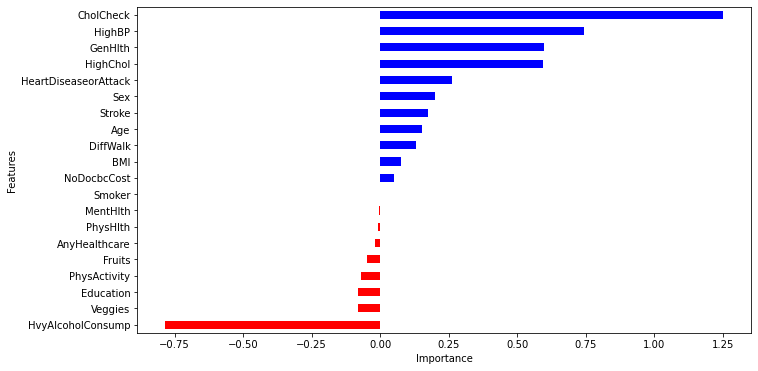

In [70]:
coeff = list(model.coef_[0])
labels = list(X_train.columns)
features = pd.DataFrame()
features['Features'] = labels
features['importance'] = coeff
features.sort_values(by=['importance'], ascending=True, inplace=True)
features['positive'] = features['importance'] > 0
features.set_index('Features', inplace=True)
features.importance.plot(kind='barh', figsize=(11, 6),color = features.positive.map({True: 'blue', False: 'red'}))
plt.xlabel('Importance')

Interpretations on the Visualization of the Weights :

1. CholCheck, HighBP, GenHlth, and HighChol have significant influence on the model.
2. HvyAlcoholConsumption has negative influence to the model, meaning that a higher HvyAlcoholConsumption correlates to a person not having diabetes
3. Initial data interpretations, like BMI and Age show that they have a high correlation to the outcome variable, but the model relies more on CholCheck, HighBP, GenHlth, and HighChol instead. (? - data needs to be normalized for this to be an accurate statement) 

In [72]:
#making predictions
sample = pd.read_csv('diabetes_binary_health_indicators_BRFSS2015.csv')

y_sample = sample.iloc[:,0]
X_sample = sample.iloc[:,1:-1]

predictionProbability = model.predict_proba(X_sample)
prediction = model.predict(X_sample)
#shows probability of being zlass '0' and class '1'
print('Probability:', predictionProbability)
print('prediction:', prediction)


Probability: [[0.06365901 0.93634099]
 [0.92601003 0.07398997]
 [0.15339036 0.84660964]
 ...
 [0.9550666  0.0449334 ]
 [0.62970589 0.37029411]
 [0.52170176 0.47829824]]
prediction: [1. 0. 1. ... 0. 0. 0.]


In [73]:
#confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_sample, prediction)
print(confusion_matrix)

[[158168  60166]
 [  8249  27097]]


Confusion Matrix Interpretations

- True positive is 158168.
- True negative is 27097.
- False positive is 60166.
- False negative is 8249.

In [74]:
from sklearn.metrics import classification_report
print(classification_report(y_sample, prediction))

              precision    recall  f1-score   support

         0.0       0.95      0.72      0.82    218334
         1.0       0.31      0.77      0.44     35346

    accuracy                           0.73    253680
   macro avg       0.63      0.75      0.63    253680
weighted avg       0.86      0.73      0.77    253680



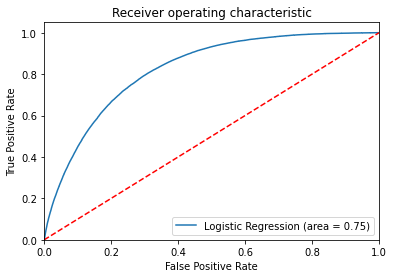

In [75]:
#ROC Curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_sample, model.predict(X_sample))
fpr, tpr, thresholds = roc_curve(y_sample, model.predict_proba(X_sample)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [76]:
'''
# Another way to apply Logistic Regression model to data 
import statsmodels.api as sm
from statsmodels.formula.api import logit

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

# Using Anova to check for significance
model1 = logit('Diabetes_binary ~ C(HighBP) + C(HighChol) + C(CholCheck) + C(BMI) + C(Smoker) + C(Stroke) + C(HeartDiseaseorAttack) + C(PhysActivity) + C(Fruits) + C(Veggies) + C(HvyAlcoholConsump) + C(AnyHealthcare) + C(NoDocbcCost) + C(GenHlth) + C(MentHlth) + C(PhysHlth) + C(DiffWalk) + C(Sex) + C(Age) + C(Education) + C(Income)', data=data).fit()

print(model1.params)
anova_table = sm.stats.anova_lm(model1, typ=2)
anova_table
'''

"\n# Another way to apply Logistic Regression model to data \nimport statsmodels.api as sm\nfrom statsmodels.formula.api import logit\n\nlogit_model=sm.Logit(y,X)\nresult=logit_model.fit()\nprint(result.summary2())\n\n# Using Anova to check for significance\nmodel1 = logit('Diabetes_binary ~ C(HighBP) + C(HighChol) + C(CholCheck) + C(BMI) + C(Smoker) + C(Stroke) + C(HeartDiseaseorAttack) + C(PhysActivity) + C(Fruits) + C(Veggies) + C(HvyAlcoholConsump) + C(AnyHealthcare) + C(NoDocbcCost) + C(GenHlth) + C(MentHlth) + C(PhysHlth) + C(DiffWalk) + C(Sex) + C(Age) + C(Education) + C(Income)', data=data).fit()\n\nprint(model1.params)\nanova_table = sm.stats.anova_lm(model1, typ=2)\nanova_table\n"